# Práctica 5 — Ajedrez
### Importación de las librerías

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from matplotlib import colors
import os

### Dataset original

A modo de exploración, se va a mostrar el conjunto de datos original sobre el que se va a trabajar



In [124]:
# Cargamos subconjunto del dataset
df = pd.read_csv('lichess_games.csv', nrows=10000)
df.head(10).to_latex('outputs/original.tex', index=False)

print(df.head(10))

       Site            White        Black Result  WhiteElo  BlackElo  \
0  eh5dKZuD       Panchito0O  PauloPeru78    1-0      1247      1218   
1  6yXyLl2M       igloknight   atacan3131    0-1      1577      1593   
2  SZW2amZz   draughts2chess     xhoxhi64    1-0      1043      1000   
3  VGhr7swl    GodofPastries    Mickey187    1-0      2015      2028   
4  aQTAJkjw        elprimo27    knocikIII    0-1      2139      2145   
5  q3nLXkE4  gustavstromberg       kaddy3    1-0      1756      1737   
6  HFLSck3z          rennbj4   XXXZeusXXX    1-0      1638      1696   
7  Iyv5e6Y1   diegocrafter44     espenono    1-0      1841      1825   
8  ULFsvszI     Not-Magnus-C    Yala_Baba    0-1      1699      1713   
9  ba6M0iTF    Nosferatu_rrr     Perinell    1-0      1496      1575   

  TimeControl  ECO                                     Opening   Termination  \
0       180+0  C25              Vienna Game: Anderssen Defense        Normal   
1       180+0  B12           Caro-Kann Defense:

### Preprocesamiento

A continuación, a fin de poder entrenar correctamente los modelos, debemos tratar ciertos atributos del dataset. A continuación se detalla el preprocesamiento exmpleado

In [125]:
# 1. Eliminamos columnas innecesarias
df = df.drop(columns=['Site', 'White', 'Black', 'Opening'])

# 2. Preprocesamiento de Elo (asumir "?" como 0)
df['WhiteElo'] = pd.to_numeric(df['WhiteElo'].replace('?', '0'))
df['BlackElo'] = pd.to_numeric(df['BlackElo'].replace('?', '0'))

# 3. Reemplazamos el valor * de Results por '1/2-1/2' (empate)
df['Result'] = df['Result'].replace('*', '1/2-1/2')

# 4. Codificación de variables categóricas
le = LabelEncoder()
columnas_a_codificar = ['Result', 'ECO', 'Termination', 'TimeControl']
for col in columnas_a_codificar:
    df[col] = le.fit_transform(df[col].astype(str))

Además, para capturar mejor la dinámica del juego, se han generado dos nuevos atributos a partir de las puntuaciones ELO originales: $GameElo$ y $EloDiff$.

El atributo $GameElo$ permite al modelo estimar la calidad general de la partida, mientras que $EloDiff$ es un indicador directo de la ventaja teórica de un jugador sobre otro.

In [126]:
# Añadimos atributos derivados
df['GameElo'] = np.ceil((df['WhiteElo'] + df['BlackElo']) / 2)
df['EloDiff'] = df['WhiteElo'] - df['BlackElo']

Finalmente, se divide el conjunto entre los atributos de entrada y la clase objetivo

In [127]:
original = df.copy()
original.head(10).to_latex('outputs/procesado.tex', index=False)

y = original['Result'].values
original = original.drop(columns=['Result'])

### Visualización de los conjuntos de datos

Se presenta la estructura del conjunto de datos resultante de aplicar las transformaciones

In [128]:


print("Datos procesados:")
print(original.head(10))
print("Numeros de instancias", original.shape[0])

print("Result:")
print(y)

# Numero de clases
num_classes = len(np.unique(y))
print(f"Número de clases: {num_classes}")

Datos procesados:
   WhiteElo  BlackElo  TimeControl  ECO  Termination  MovesCount  GameElo  \
0      1247      1218           17  152            1          15   1233.0   
1      1577      1593           17   75            2          52   1585.0   
2      1043      1000           17  204            1          44   1022.0   
3      2015      2028           17   76            1          29   2022.0   
4      2139      2145           17   73            1          56   2142.0   
5      1756      1737           17   69            1          21   1747.0   
6      1638      1696           17   35            2          45   1667.0   
7      1841      1825           17  135            1          45   1833.0   
8      1699      1713           17  161            1          29   1706.0   
9      1496      1575           17  147            1          24   1536.0   

   EloDiff  
0       29  
1      -16  
2       43  
3      -13  
4       -6  
5       19  
6      -58  
7       16  
8      -14  
9   

Mostramos las métricas de cada uno de los atributos del dataset, para comprender la escala y dispersión de cada atributo.

In [129]:
original.describe()

,WhiteElo,BlackElo,TimeControl,ECO,Termination,MovesCount,GameElo,EloDiff
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1664.974100,1663.98160,42.034600,106.687300,1.341600,33.292400,1664.726700,0.992500
std,392.844348,392.56635,23.124962,72.977249,0.479513,15.003533,389.457589,100.708536
min,462.000000,418.00000,0.000000,0.000000,0.000000,0.000000,493.000000,-1154.000000
25%,1390.000000,1386.00000,17.000000,41.000000,1.000000,23.000000,1394.000000,-28.000000
50%,1677.000000,1675.00000,39.000000,85.000000,1.000000,32.000000,1679.000000,0.000000
75%,1938.000000,1937.00000,63.000000,169.000000,2.000000,42.000000,1937.000000,29.000000
max,3156.000000,3153.00000,94.000000,304.000000,3.000000,149.000000,3155.000000,1352.000000


Creamos una función *dibujarScatter* que implementa la creación automática de gráficas de dispersión.

In [130]:
TARGET_NAMES = ['0-1', '1-0', '1/2-1/2']

def dibujarScatter(set, title, feature1, feature2):
     fig, ax = plt.subplots()
     scatter = ax.scatter(set[feature1], set[feature2], c=y, cmap='viridis')
     # Leyenda utilizando TARGET_NAMES
     handles, _ = scatter.legend_elements()
     legend1 = ax.legend(handles, TARGET_NAMES, title="Results") 
     ax.add_artist(legend1)
     plt.title(title)
     plt.xlabel(feature1)
     plt.ylabel(feature2)
     plt.show()

Se muestra a continuación la relación entre la diferencia de nivel EloDiff, el resultado de la partida y la duración de la misma MovesCount.

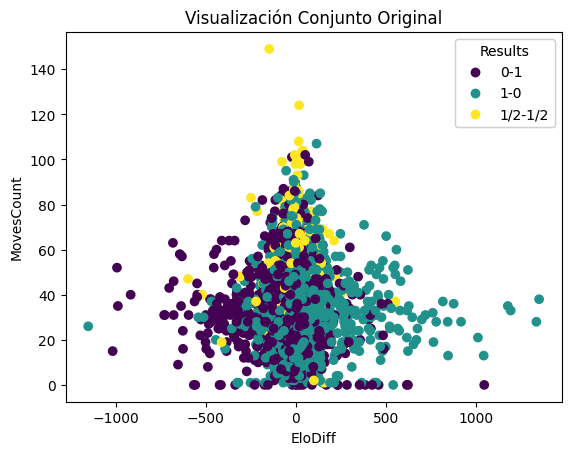

In [131]:
dibujarScatter(original, "Visualización Conjunto Original", 'EloDiff', 'MovesCount')

Se observa que cuanto más cercana a 0 es la diferencia de ELO, más movimientos se realizan en la partida. Mientras que cuanto más alejada hacia el extremo positivo, más frecuente es la victoria del Blanco, y viceversa con el Negro.

### Estandarización

Vamos a estandarizar el conjunto de datos a escala unitaria, es decir: 
$
\\
\hspace{1cm}    media = 0
\hspace{1cm}    varianza = 1
$

In [132]:
# Obtenemos el conjunto de datos estandarizado
standarized = StandardScaler().fit_transform(original)

standarized = pd.DataFrame(standarized, columns=original.columns)

standarized.head(10).to_latex('outputs/estandarizado.tex', index=False)
print(standarized.head(10))

   WhiteElo  BlackElo  TimeControl       ECO  Termination  MovesCount  \
0 -1.064022 -1.136124    -1.082633  0.620946    -0.712426   -1.219267   
1 -0.223953 -0.180823    -1.082633 -0.434230     1.373129    1.246942   
2 -1.583338 -1.691472    -1.082633  1.333533    -0.712426    0.713708   
3  0.891049  0.927325    -1.082633 -0.420526    -0.712426   -0.286107   
4  1.206711  1.225379    -1.082633 -0.461637    -0.712426    1.513559   
5  0.231721  0.186012    -1.082633 -0.516451    -0.712426   -0.819341   
6 -0.068667  0.081566    -1.082633 -0.982373     1.373129    0.780362   
7  0.448103  0.410189    -1.082633  0.387986    -0.712426    0.780362   
8  0.086619  0.124873    -1.082633  0.744279    -0.712426   -0.286107   
9 -0.430151 -0.226678    -1.082633  0.552429    -0.712426   -0.619378   

    GameElo   EloDiff  
0 -1.108589  0.278118  
1 -0.204722 -0.168738  
2 -1.650395  0.417140  
3  0.917407 -0.138948  
4  1.225543 -0.069437  
5  0.211262  0.178817  
6  0.005837 -0.585804  
7  0

### Normalización

Otra alternativa posible a la estandarización es normalizar los datos a un rango [0,1], para poder reducir su escala.

In [134]:
normalized = MinMaxScaler().fit_transform(original)
normalized = pd.DataFrame(normalized, columns=original.columns)

normalized.head(10).to_latex('outputs/normalizado.tex', index=False)
print(normalized.head(10))

   WhiteElo  BlackElo  TimeControl       ECO  Termination  MovesCount  \
0  0.291388  0.292505     0.180851  0.500000     0.333333    0.100671   
1  0.413883  0.429616     0.180851  0.246711     0.666667    0.348993   
2  0.215664  0.212797     0.180851  0.671053     0.333333    0.295302   
3  0.576466  0.588665     0.180851  0.250000     0.333333    0.194631   
4  0.622494  0.631444     0.180851  0.240132     0.333333    0.375839   
5  0.480327  0.482267     0.180851  0.226974     0.333333    0.140940   
6  0.436526  0.467276     0.180851  0.115132     0.666667    0.302013   
7  0.511878  0.514442     0.180851  0.444079     0.333333    0.302013   
8  0.459169  0.473492     0.180851  0.529605     0.333333    0.194631   
9  0.383816  0.423035     0.180851  0.483553     0.333333    0.161074   

    GameElo   EloDiff  
0  0.277986  0.472067  
1  0.410218  0.454110  
2  0.198723  0.477654  
3  0.574380  0.455307  
4  0.619459  0.458101  
5  0.471074  0.468077  
6  0.441022  0.437350  
7  0

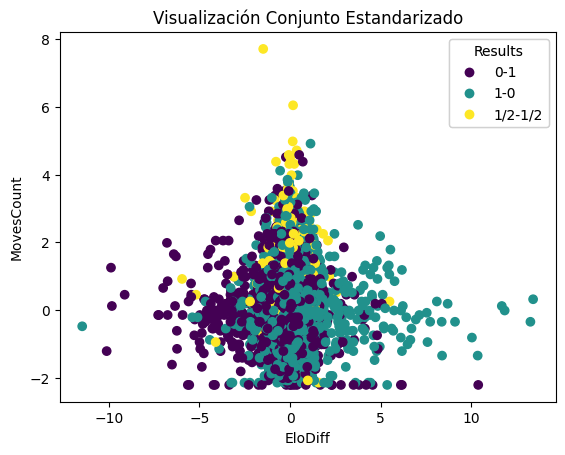

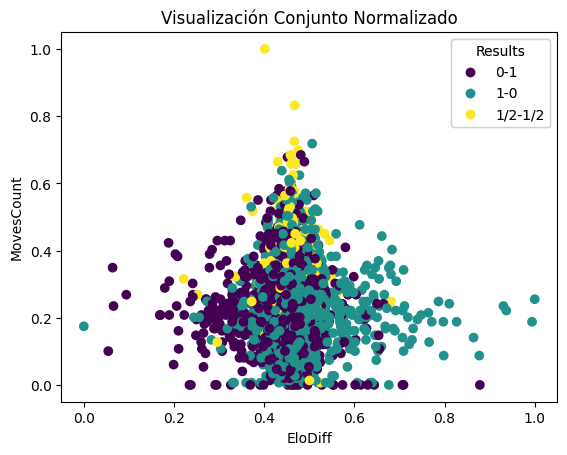

In [140]:
# Mostramos scatter del conjunto estandarizado
dibujarScatter(standarized, "Visualización Conjunto Estandarizado", 'EloDiff', 'MovesCount')

# Mostramos scatter del conjunto normalizado
dibujarScatter(normalized, "Visualización Conjunto Normalizado", 'EloDiff', 'MovesCount')

Se puede observar que ambos presentan la misma distribuicón que el conjunto de datos original. Debido a la naturaleza de la estandarización y la normalización, tan solo cambian los valores en los ejes, ya que se mantienen las proporciones con respecto al original

### Calculo de Componentes Principales (PCA)

Vamos a aplicar la técnica de PCA a los conjuntos de los datos que hemos obtenido, para poder reducir su dimensionalidad, manteniendo la máxima información posible. Probaremos con dos ajustes distintos, uno que mantenga una varianza explicada de hasta el 95%, y otro que se quede en 80%.

In [136]:
def mostrar_pca(pca, pca_data, y, ax, title=""):
    if pca_data.shape[1] == 1: 
        ax.set_title(title + f"\nVarianza: {pca.explained_variance_ratio_[0]*100:.2f}%")
        ax.scatter(pca_data[:, 0], np.zeros(pca_data.shape[0]), c=y, cmap=plt.cm.Set1, edgecolor="k")
        ax.set_xlabel("Componente principal 1")

    else:
        total_var = (pca.explained_variance_ratio_.sum()) * 100
        ax.set_title(title + f"\nVarianza total: {total_var:.2f}%")
        ax.scatter(pca_data[:, 0], pca_data[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
        ax.set_xlabel("Componente 1")
        ax.set_ylabel("Componente 2")

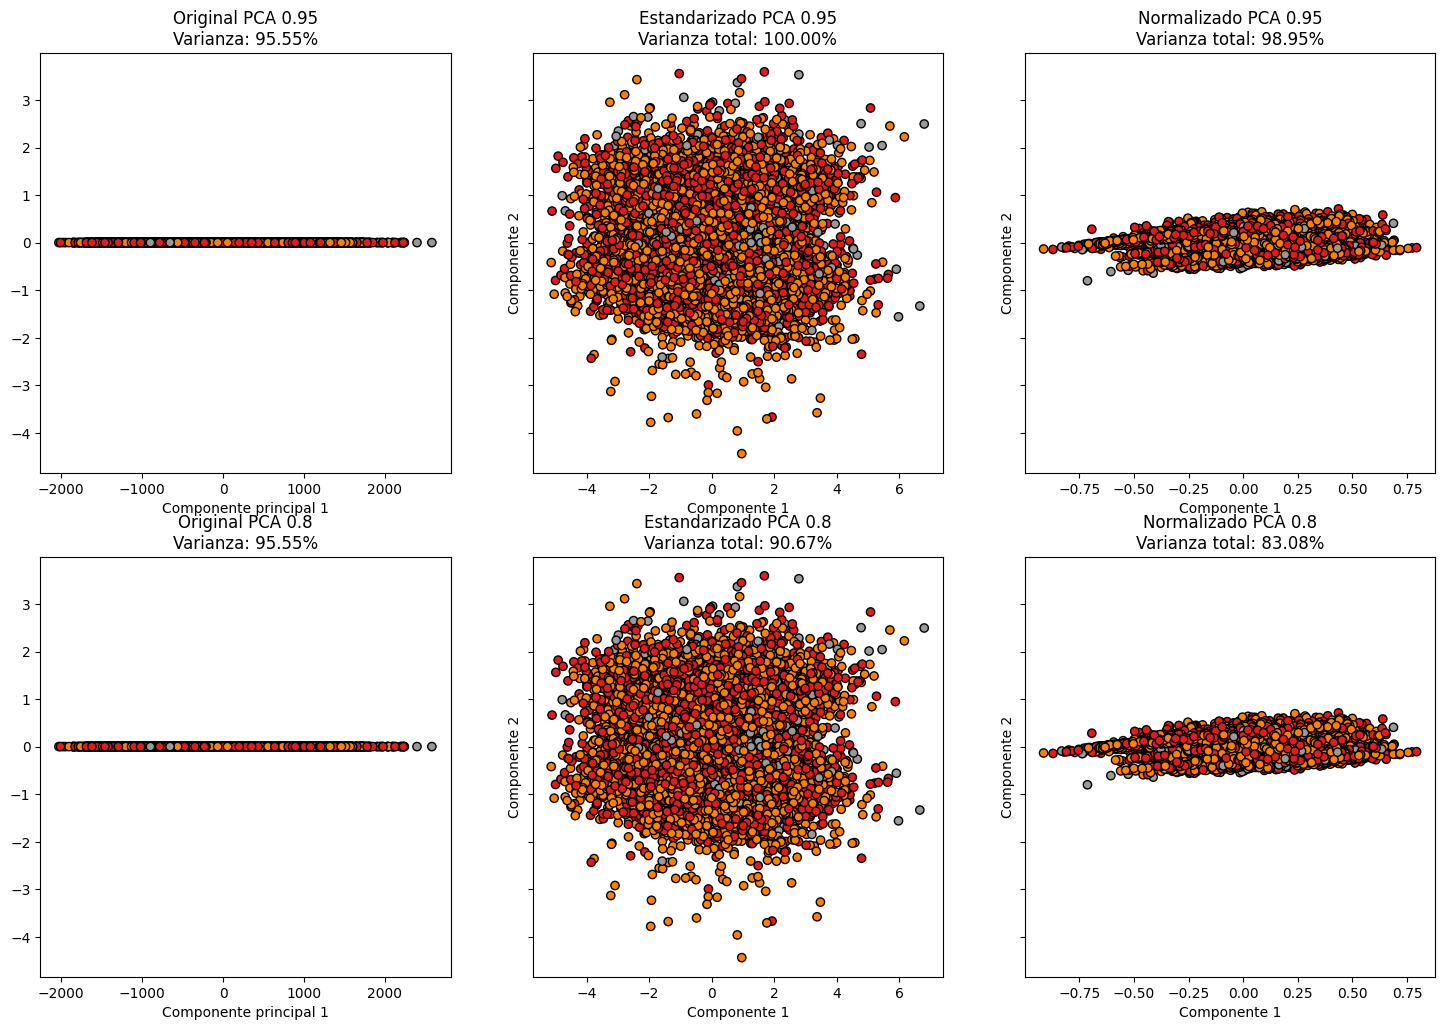

In [149]:
pca95 = PCA(n_components=0.95)
pca80 = PCA(n_components=0.8)

# Creamos una sola figura con 6 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), sharey=True)


# PCA 0.95
original_pca95 = pd.DataFrame(pca95.fit_transform(original), columns=[f'PC{i+1}' for i in range(pca95.n_components_)])
var_original_95 = pca95.explained_variance_ratio_.sum()
mostrar_pca(pca95, pca95.fit_transform(original), y, axes[0, 0], "Original PCA 0.95")

standarized_pca95 = pd.DataFrame(pca95.fit_transform(standarized), columns=[f'PC{i+1}' for i in range(pca95.n_components_)])
var_standarized_95 = pca95.explained_variance_ratio_.sum()
mostrar_pca(pca95, pca95.fit_transform(standarized), y, axes[0, 1], "Estandarizado PCA 0.95")

normalized_pca95 = pd.DataFrame(pca95.fit_transform(normalized), columns=[f'PC{i+1}' for i in range(pca95.n_components_)])
var_normalized_95 = pca95.explained_variance_ratio_.sum()
mostrar_pca(pca95, pca95.fit_transform(normalized), y, axes[0, 2], "Normalizado PCA 0.95")

# PCA 0.8
original_pca80 = pd.DataFrame(pca80.fit_transform(original), columns=[f'PC{i+1}' for i in range(pca80.n_components_)])
var_original_80 = pca80.explained_variance_ratio_.sum()
mostrar_pca(pca80, pca80.fit_transform(original), y, axes[1, 0], "Original PCA 0.8")

standarized_pca80 = pd.DataFrame(pca80.fit_transform(standarized), columns=[f'PC{i+1}' for i in range(pca80.n_components_)])
var_standarized_80 = pca80.explained_variance_ratio_.sum()
mostrar_pca(pca80, pca80.fit_transform(standarized), y, axes[1, 1], "Estandarizado PCA 0.8")

normalized_pca80 = pd.DataFrame(pca80.fit_transform(normalized), columns=[f'PC{i+1}' for i in range(pca80.n_components_)])
var_normalized_80 = pca80.explained_variance_ratio_.sum()
mostrar_pca(pca80, pca80.fit_transform(normalized), y, axes[1, 2], "Normalizado PCA 0.8")

pca = [
    ['Original PCA 95', original_pca95.shape[1], var_original_95],
    ['Standarized PCA 95', standarized_pca95.shape[1], var_standarized_95],
    ['Normalized PCA 95', normalized_pca95.shape[1], var_normalized_95],
    ['Original PCA 80', original_pca80.shape[1], var_original_80],
    ['Standarized PCA 80', standarized_pca80.shape[1], var_standarized_80],
    ['Normalized PCA 80', normalized_pca80.shape[1], var_normalized_80]
]

try:
    os.mkdir('outputs')
except FileExistsError:
    pass

pd.DataFrame(
    pca, 
    columns=['PCA Type', 'Number of Components', 'Variance Explained']
).to_latex('outputs/pca_components.tex', index=False)

## Validación Cruzada

Finalmente, se procede a realizar una validación cruzada de 5 folds para los 3 conjuntos generados (original, estandarizado y normalizado), y para sus variantes de PCA (80 y 95).

In [138]:
def generate_train_test_set(kf, data, name):
    try:
        os.mkdir(path=f'data/{name}')
    except FileExistsError:
        pass

    for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
        
        X_train = data.iloc[train_idx]
        X_test = data.iloc[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]

        training = pd.DataFrame(
            np.concatenate((X_train, y_train.reshape(y_train.shape[0], 1)), axis=1)
        )
        test = pd.DataFrame(
            np.concatenate((X_test, y_test.reshape(y_test.shape[0], 1)), axis=1)
        )

        training.to_csv(f"data/{name}/training{fold + 1}_{name}.csv", index=False)
        test.to_csv(f"data/{name}/test{fold + 1}_{name}.csv", index=False)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Diccionario con todos los conjuntos de datos para iterar
datasets = {
    "original": original,
    "standarized": standarized,
    "normalized": normalized,
    "original_pca_95": original_pca95,
    "original_pca_80": original_pca80,
    "standarized_pca_95": standarized_pca95,
    "standarized_pca_80": standarized_pca80,
    "normalized_pca_95": normalized_pca95,
    "normalized_pca_80": normalized_pca80
}

for nombre, ds in datasets.items():
    generate_train_test_set(kf, ds, nombre)